## Libraries

In [489]:
import numpy as np
import pandas as pd

from pandas.io.json import json_normalize

import json, requests
from bs4 import BeautifulSoup

import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import zscore

## Wikipedia Data scraping

### Scrape top-50 Cities from Wikipedia

In [2]:
wiki_url = requests.get('https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population').text

In [314]:
def wiki_scraper(url):
    """Scrapes the given URL for the requested column in a given Wikipedia Table
    Parameters:
    -----------
    url: Page URL for fetching table data.
    Returns:
    --------
    city_state : list, it contain cities and states in india ranked by population.
    """
    soup = BeautifulSoup(url, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    links = table.find_all(['b','a'])
    city_state = []

    for link in links:
        title = link.get('title')
        if title != None:
            city_state.append(title)
    return city_state

In [318]:
city_state_list = wiki_scraper(url=wiki_url)

### Data cleaning

In [321]:
list_city = city_state_list[0::2][0:50] ## Top 50 cities, ignoring states.

In [322]:
def clean(w):
    """Function to correct indentations and remove added dashes"""
    if '–' in w:
        w = w.replace('–', ' ')
    elif ',' in w:
        w = w.replace(',', ' ')
    elif '-' in w:
        w = w.replace('-', ' ')
    else:
        w = w
    return w.lower()
list_city = list(map(clean, list_city[0:50]))

In [324]:
def clean2(s):
    """Function to standardize name of the top-50 cities in a format acceptable by openweather
    Example:
    --------
    >>> 'visakhapatnam'
    [] 'vishakhapatnam'
    >>> 'kota  rajasthan'
    [] 'kota'
    >>> 'hubli dharwad'
    [] 'dharwad'
    """
    if 'pimpri ' in s:
        s = s.replace('pimpri ','')
    elif ' uttar pradesh' in s:
        s = s.replace(' uttar pradesh', '')
    elif ' dombivli' in s:
        s = s.replace(' dombivli','')
    elif 'vasai ' in s:
        s = s.replace('vasai ', '')
    elif ' maharashtra' in s:
        s = s.replace(' maharashtra', '')
    elif ' rajasthan' in s:
        s = s.replace(' rajasthan','')
    elif 'hubli ' in s:
        s = s.replace('hubli ', '')
    elif 'visakhapatnam' in s:
        s = s.replace('visakhapatnam', 'vishakhapatnam')
    else:
        s = s
    return s

### Fetching final list of city in an acceptable format
final_city_list =  list(map(clean2, list_city))

## OpenWeatherData scraping

#### API Key

In [51]:
# API Key = '<Create an API KEY>'

### Scraping

In [375]:
### Dataset for storing City Info
city_dataset= pd.DataFrame(columns=['id', 'name', 'country', 'timezone', 'sunrise', 'sunset', 'coord.lat',
       'coord.lon'])

### Main Dataset of Weather info
merged_dataset = pd.DataFrame(columns=['temp', 'temp_min', 'temp_max', 'pressure', 'sea_level', 'grnd_level',\
                                        'humidity', 'wind_speed', 'wind_deg', 'main', 'description', 'Country',\
                                        'Latitude', 'Longitude', 'date', 'time', 'City', 'temp_avg'])


In [376]:
base_url="http://api.openweathermap.org/data/2.5/forecast?"
api_key = '<API KEY>'


print("Beginning Data Retrieval")
print("-"*40)

non_fetched_city = [] # For storing cities whose data wasn't captured
for city in final_city_list:
    
    time.sleep(1) # To Avoid API Blocking
    
    city_name=city
    
    query_url=f"{base_url}appid={api_key}&units=metric&q="+city_name
    response=requests.get(query_url).json()
    try:
        df = json_normalize(response['list']) # Temporary dataset
        df = df.drop(columns= ['dt','main.temp_kf','clouds.all','sys.pod', 'rain.3h', 'weather'],axis=1,errors='ignore') # dropping unnecessary columns
        # renaming columns
        df.columns = ['date_time', 'temp', 'temp_min',
               'temp_max', 'pressure', 'sea_level', 'grnd_level',
               'humidity',  'wind_speed', 'wind_deg']

        ## Unpacking Weather column
        weather_df =  json_normalize(data=response['list'], record_path='weather',
                                    errors='ignore')

        weather_df = weather_df.drop(columns = ['id', 'icon'], axis=1)

        # Merging weather and main data
        df = df.merge(weather_df,left_on=None, right_on=None, left_index=True, right_index=True)
        
        df['Country'] = response['city']['country']
        df['Latitude'] = response['city']['coord']['lat']
        df['Longitude'] = response['city']['coord']['lon']
        df['date'] = df['date_time'].apply(lambda x: x[:10]) # Contains Date in string format
        df['time'] = df['date_time'].apply(lambda x: x[11:]) # contains Time in string format
        df['City'] = response['city']['name']

#         df = df.drop(columns=['date_time'], axis=1)
        df['temp_avg']= (df['temp_min']+ df['temp_max'])/2

        merged_dataset = pd.concat([merged_dataset,df], axis=0, sort=False)

        #### Table for City Info

        city_info = json_normalize(response['city'])


        city_dataset = pd.concat([city_dataset, city_info], axis=0, sort=False)
    except (KeyError, ValueError, IndexError):
        print('City Not Fetched',city_name)
        non_fetched_city.append(city_name)

print("-"*40)            
print("Data Retrieval Complete")  
print("-"*40)

Beginning Data Retrieval
----------------------------------------
----------------------------------------
Data Retrieval Complete
----------------------------------------


In [435]:
# conversion of categorical to Numeric
merged_dataset['humidity'] = merged_dataset['humidity'].apply(pd.to_numeric)

## Saving Data

In [436]:
# Saving Data in a serialized format
merged_dataset.to_pickle('City_wise_5d_3h_forecast.pkl')

city_dataset.to_pickle('City_Info.pkl')

## Data Visualization

### City wise Average Temperature - 3 Hour window

In [396]:
### Data Aggregation on a 'City' and 'Time' level
city_temp = pd.DataFrame(merged_dataset.groupby(['City', 'time'], as_index=False)\
                         ['temp_avg'].agg(lambda x: \
                                          np.mean(tuple(np.round(x,\
                                                         decimals=2).tolist()))))

# Converting 'Time' column to date-time format
city_temp['time'] = pd.to_datetime(city_temp['time'])

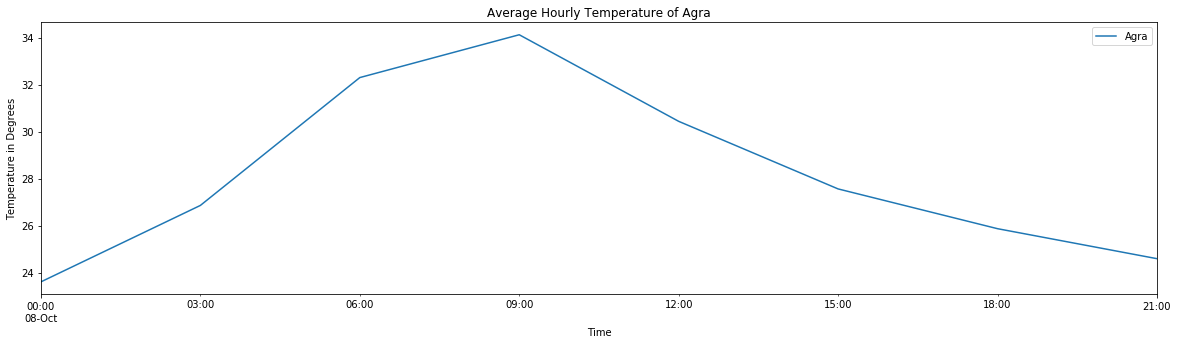

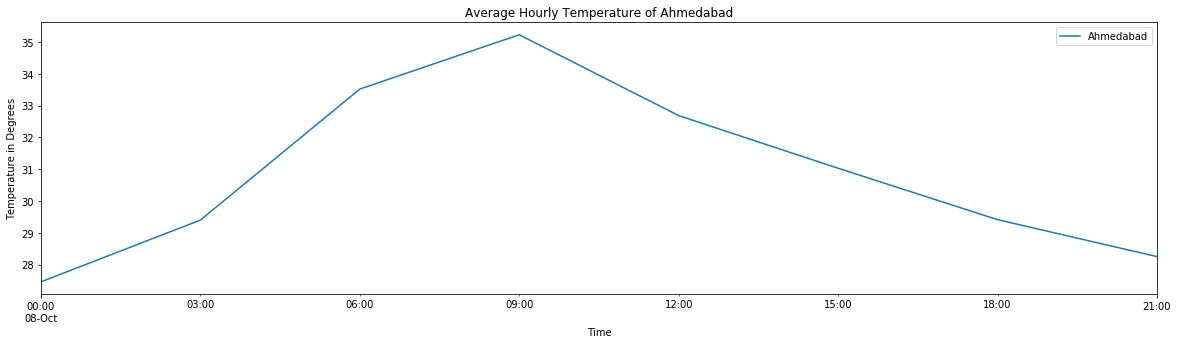

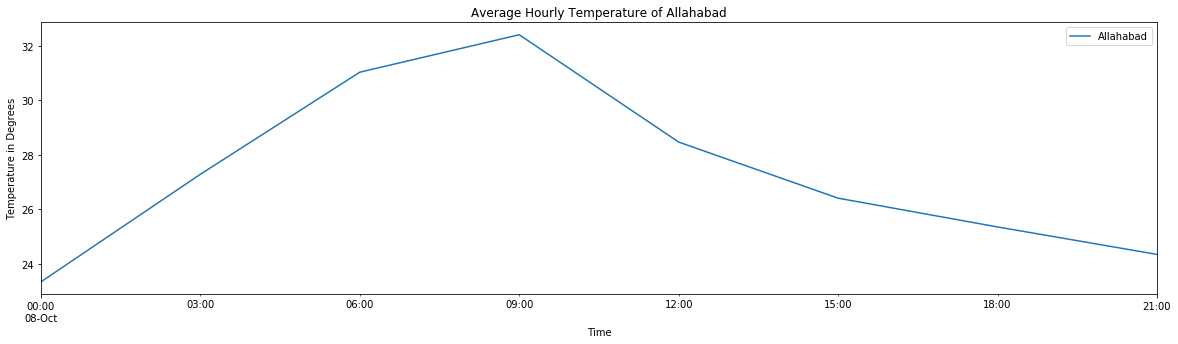

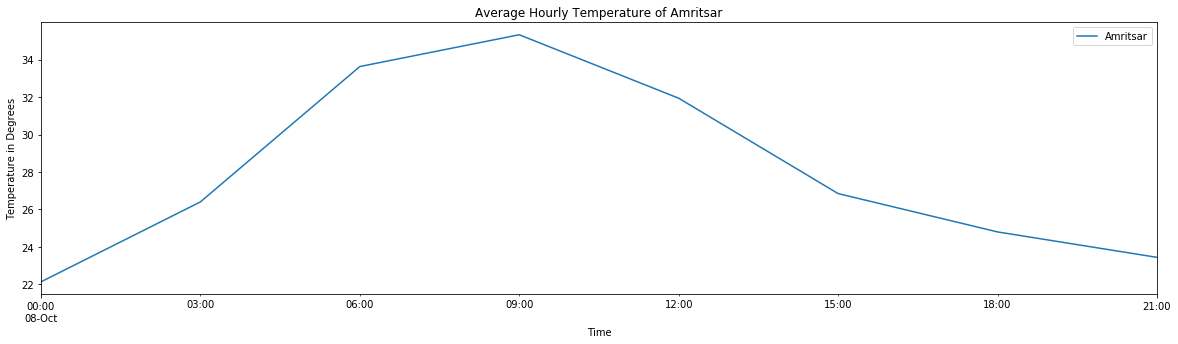

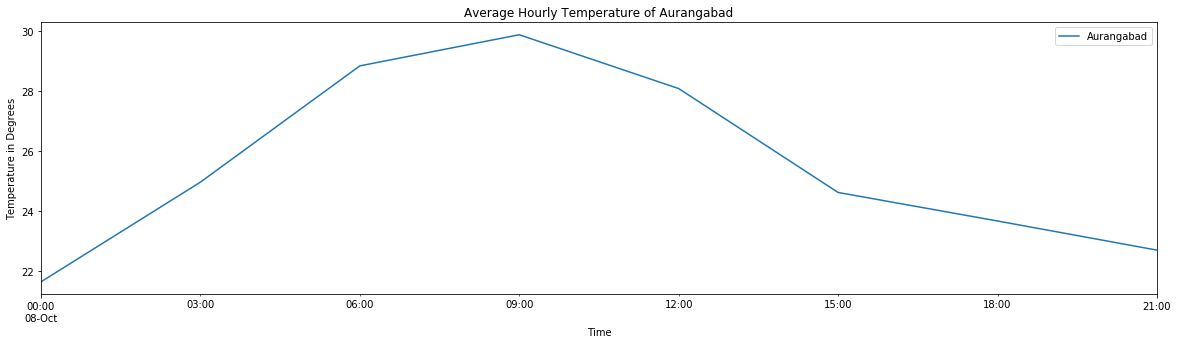

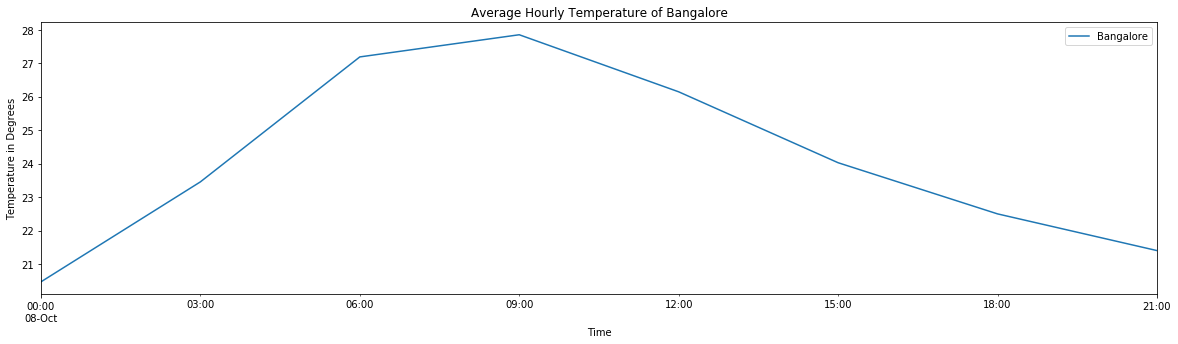

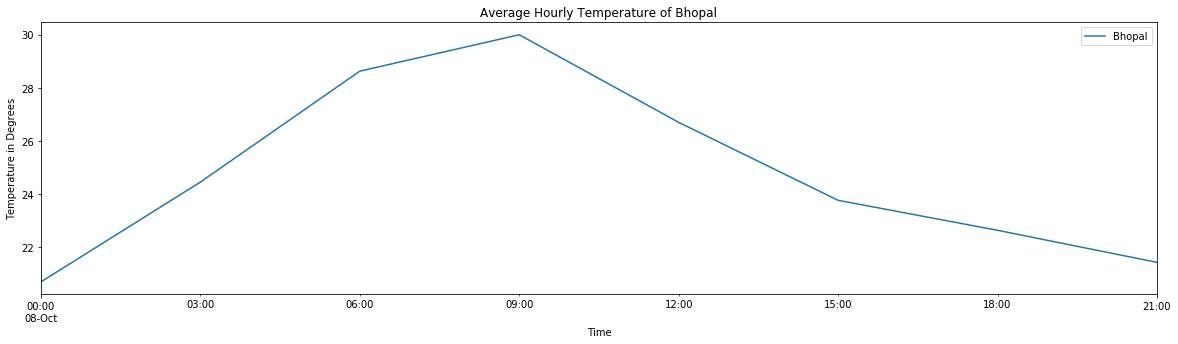

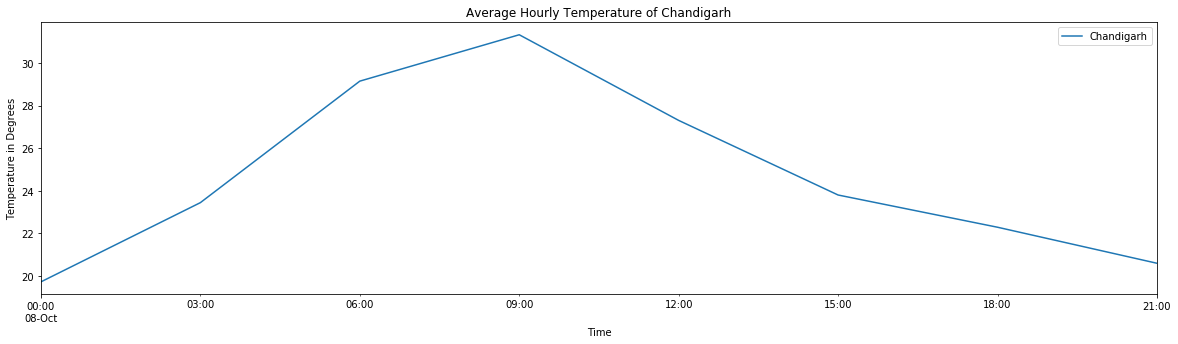

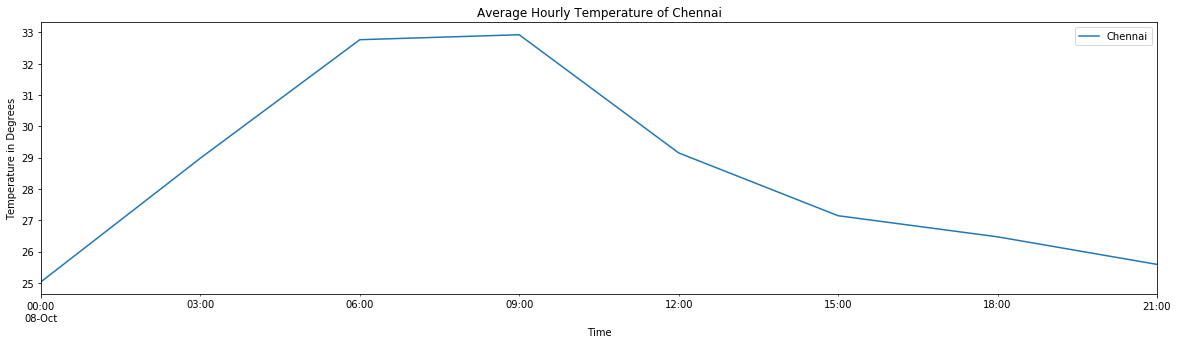

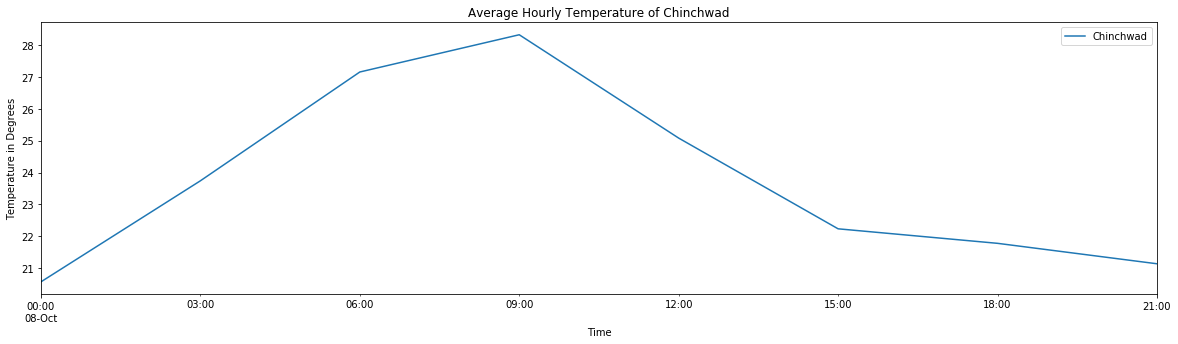

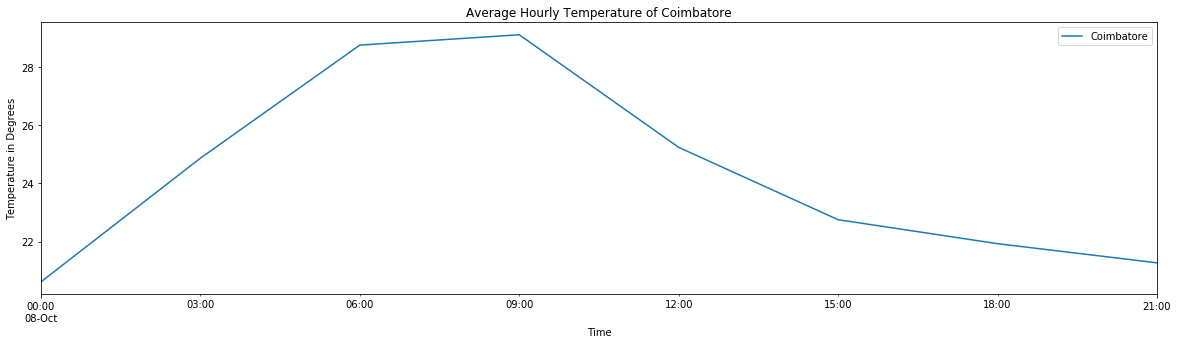

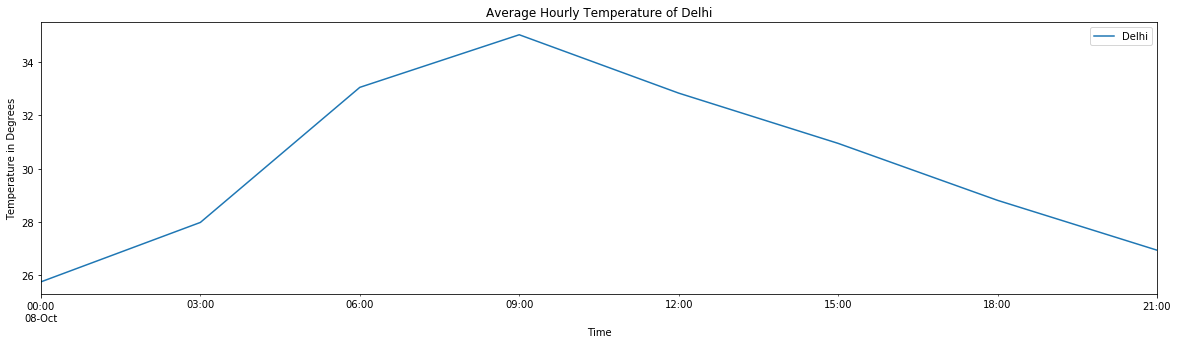

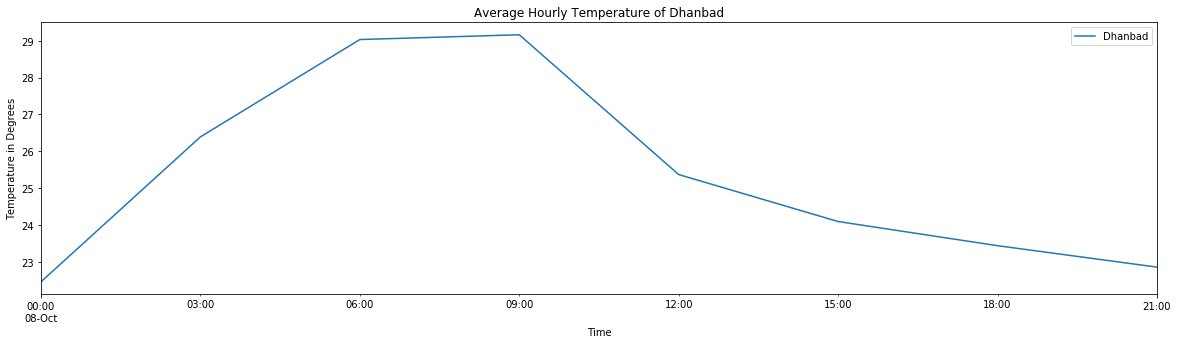

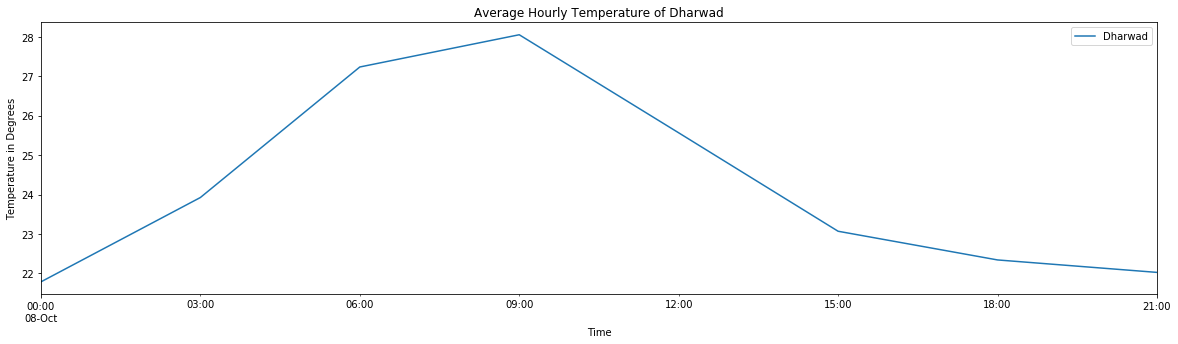

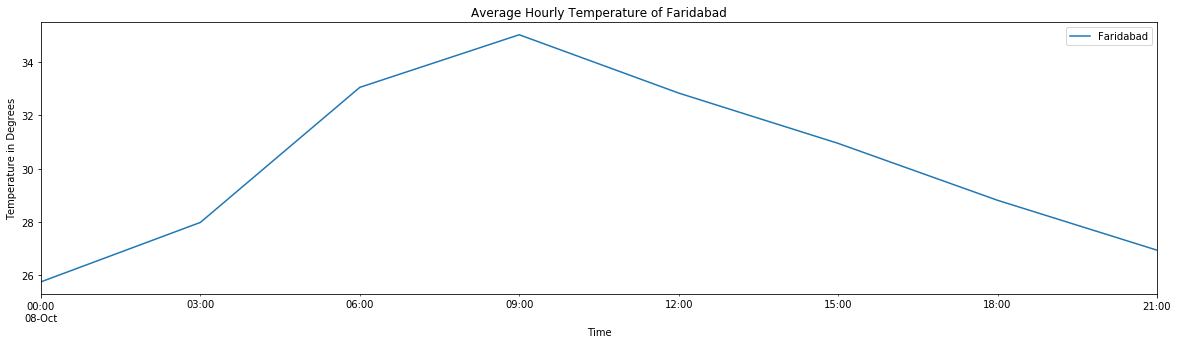

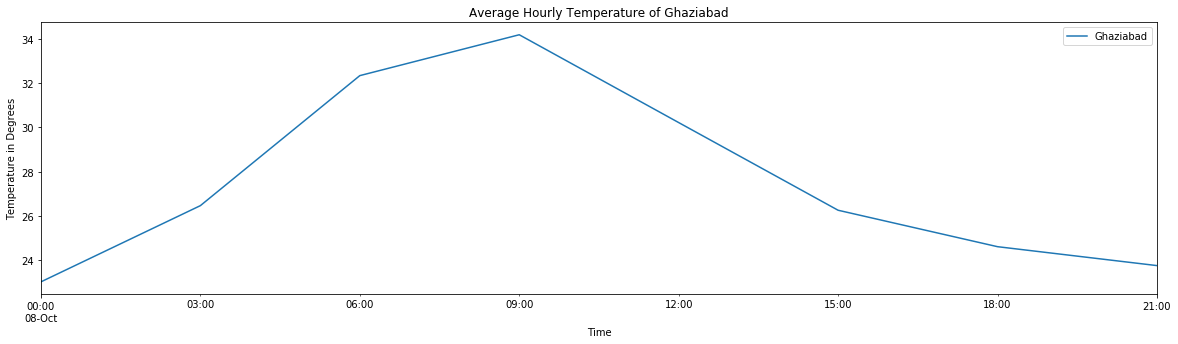

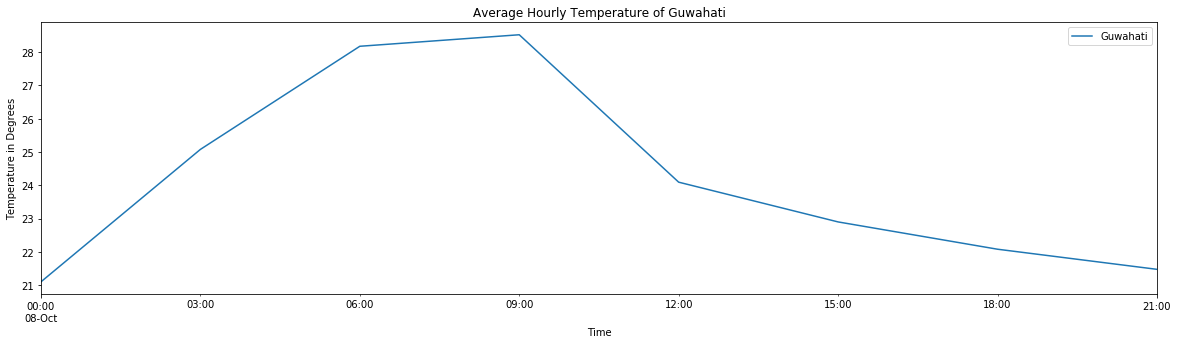

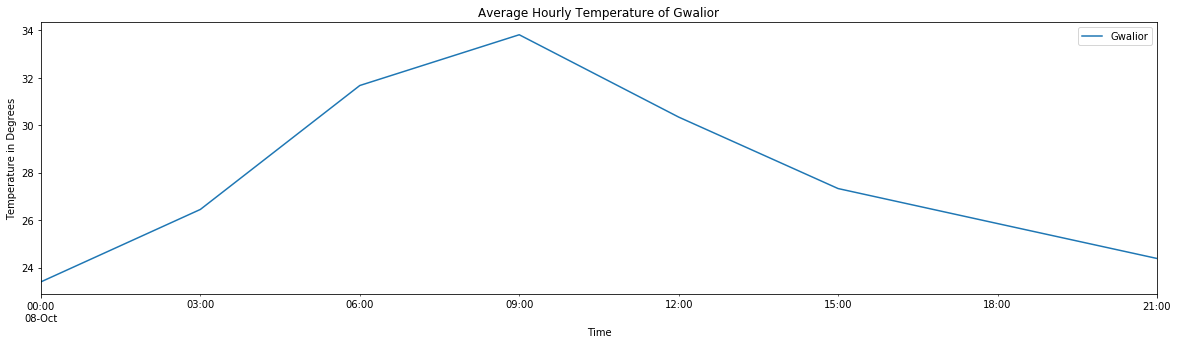

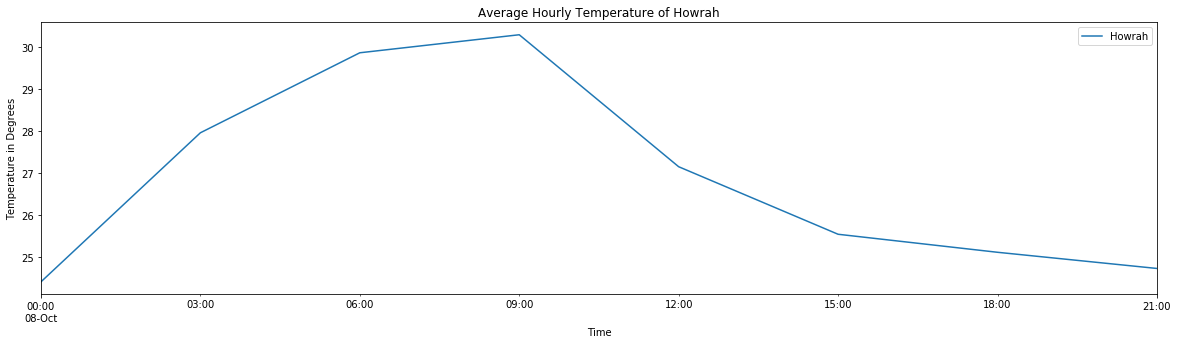

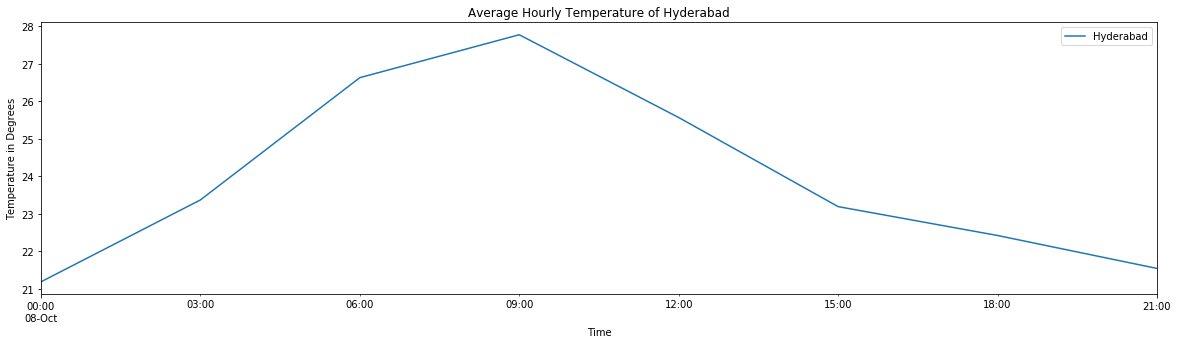

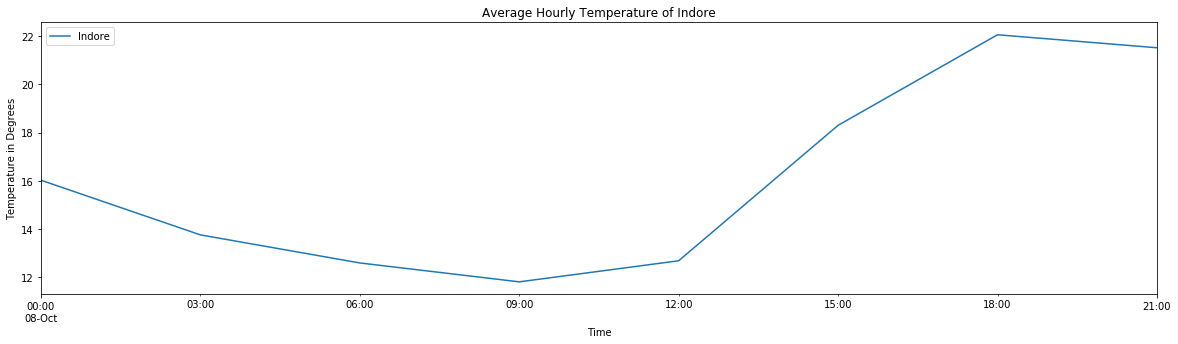

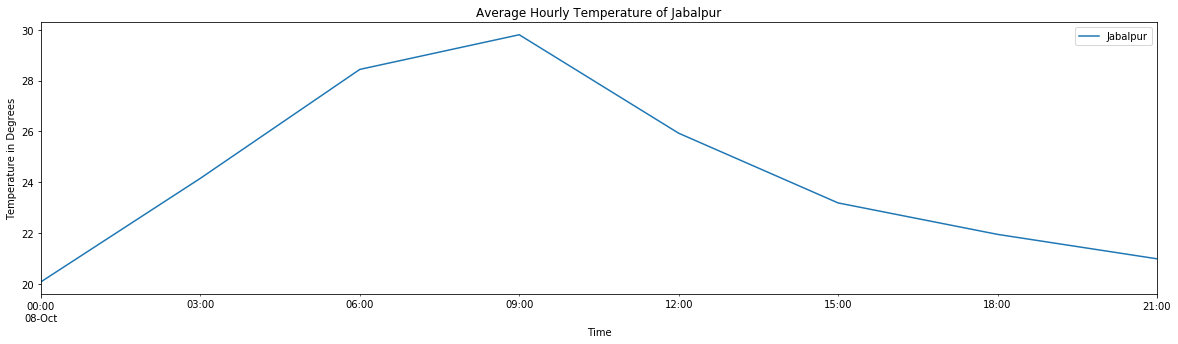

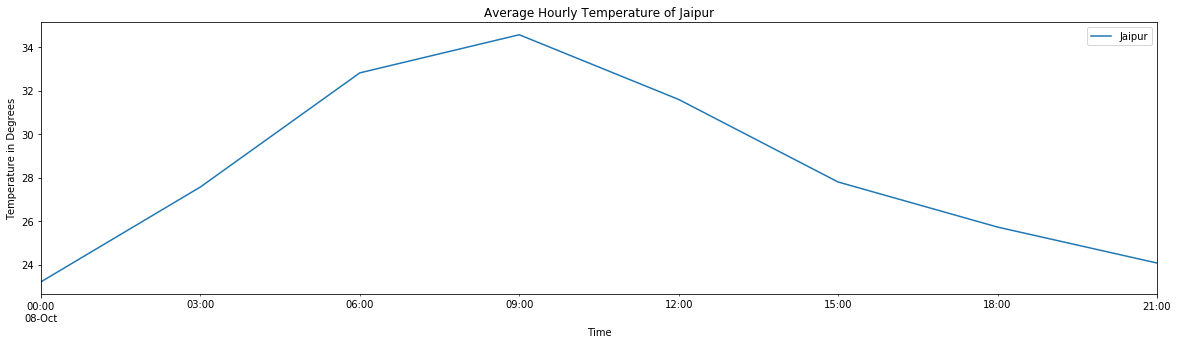

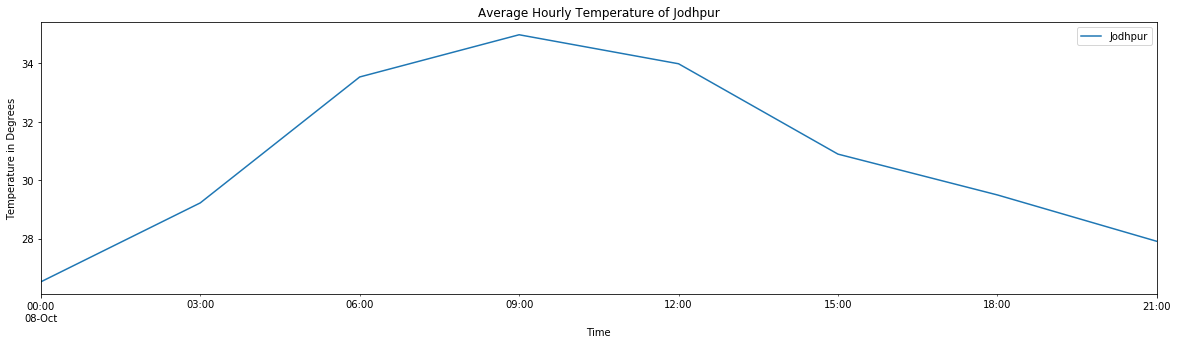

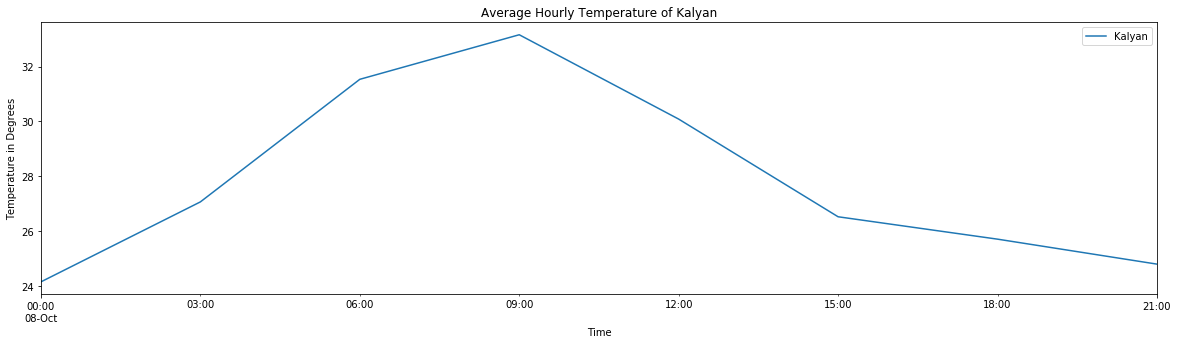

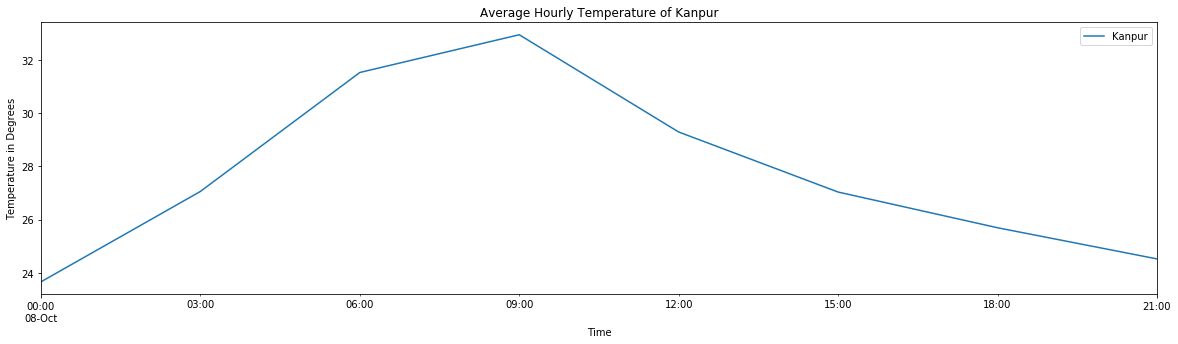

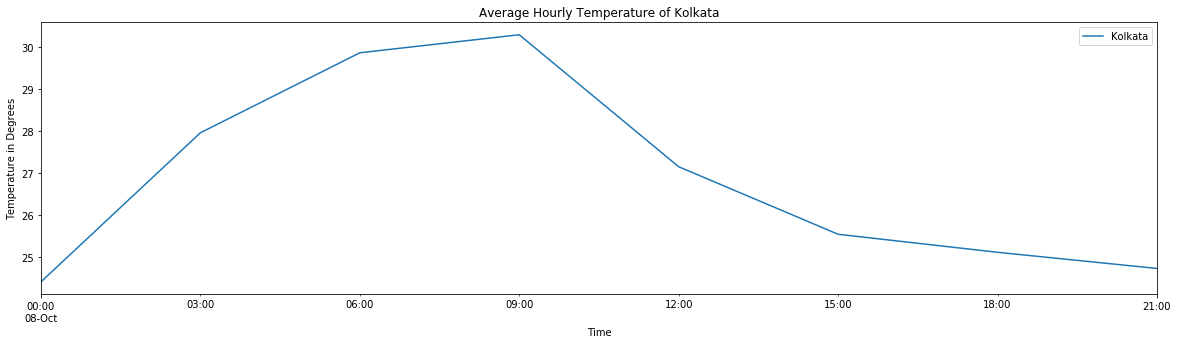

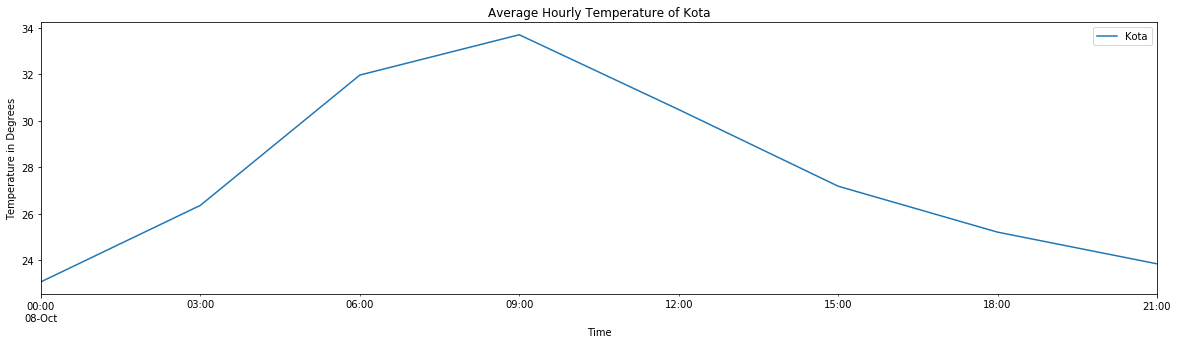

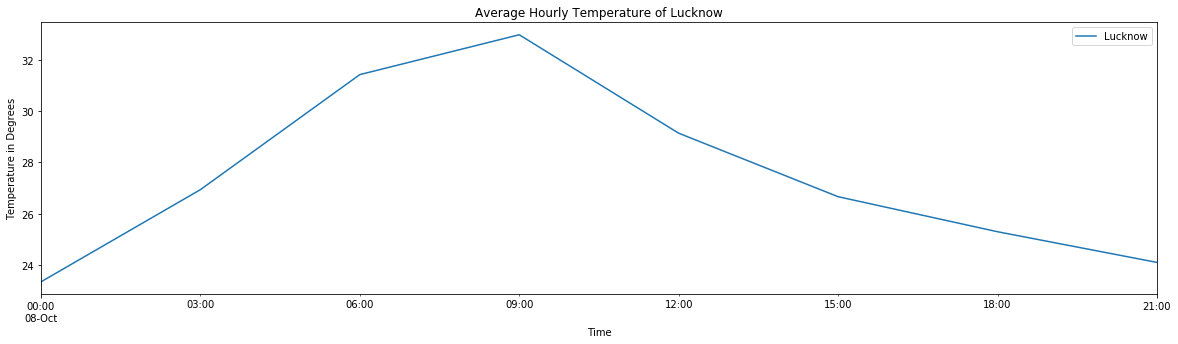

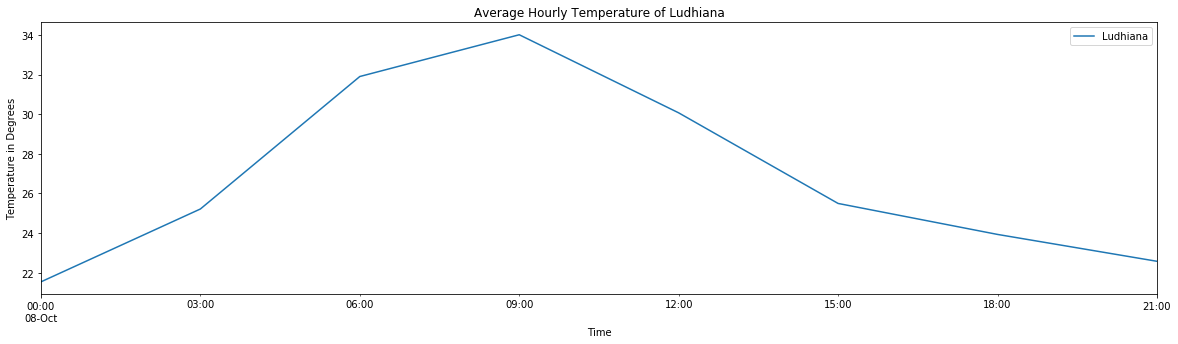

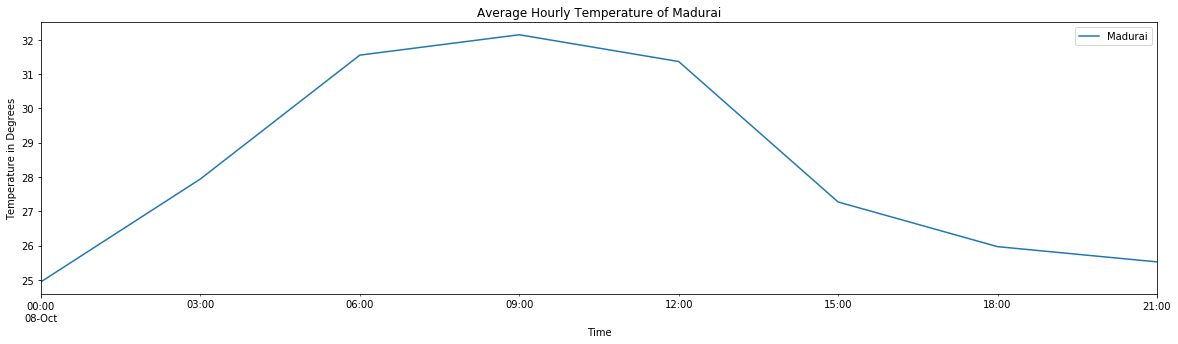

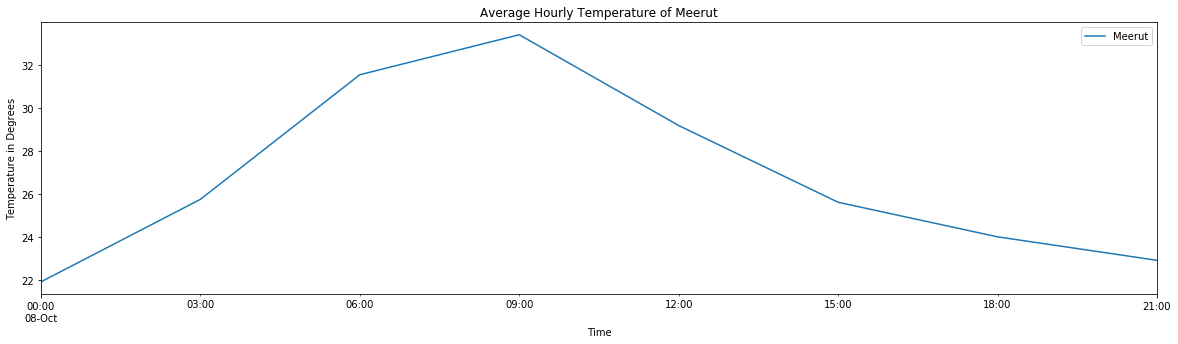

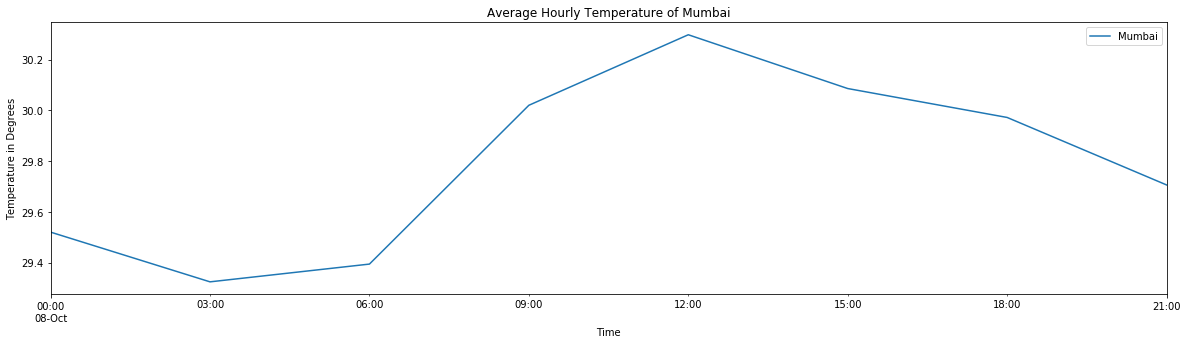

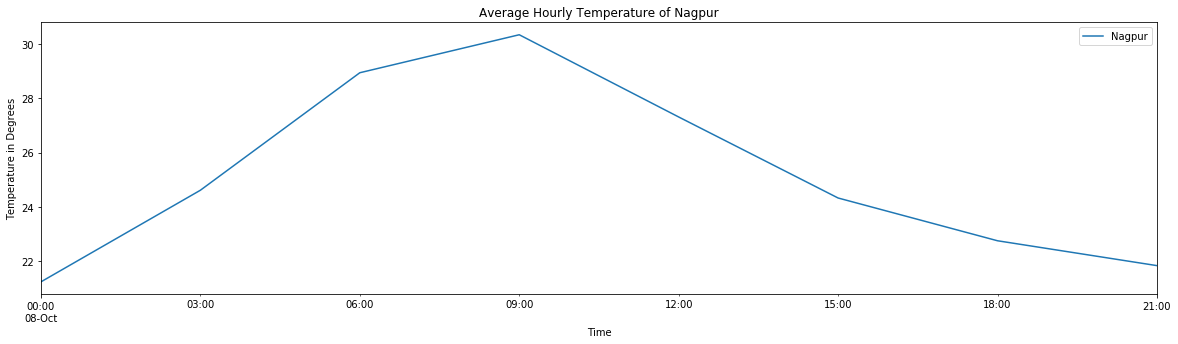

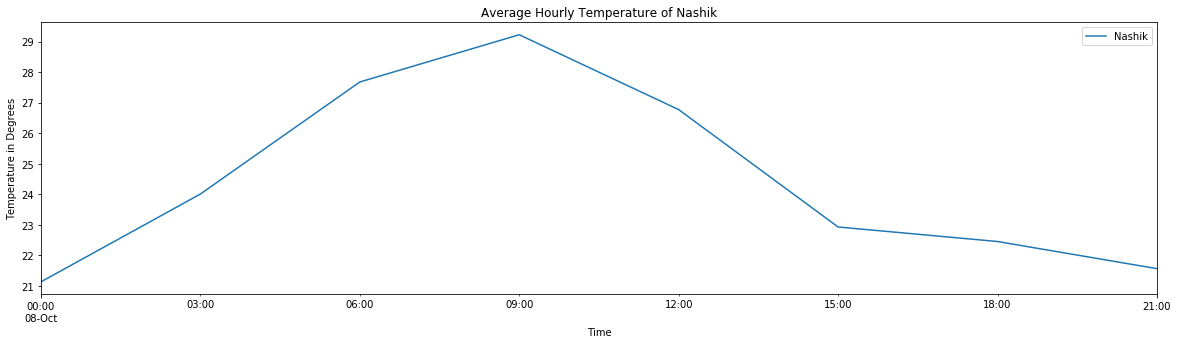

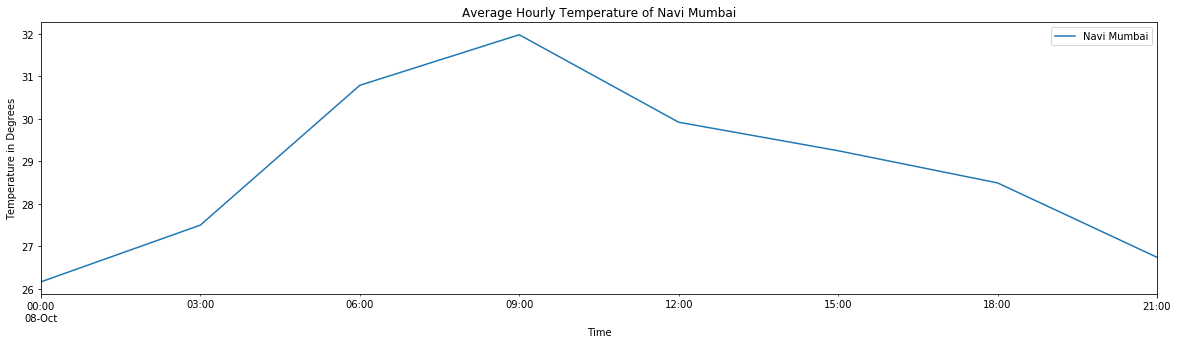

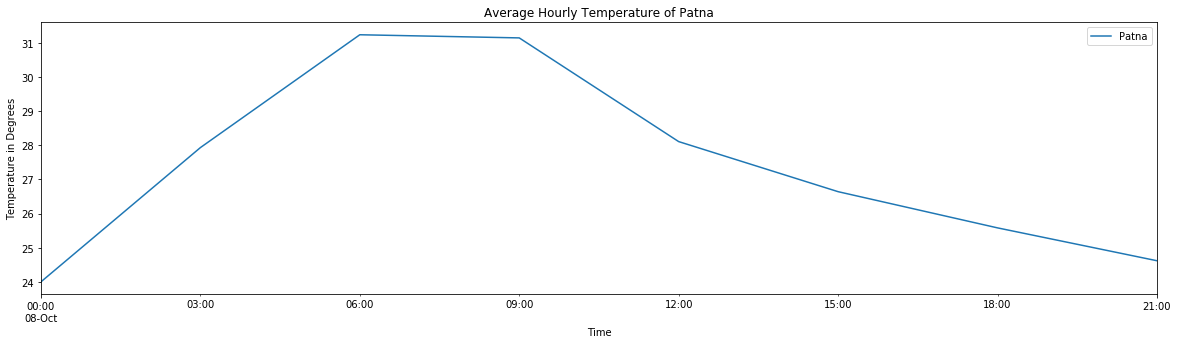

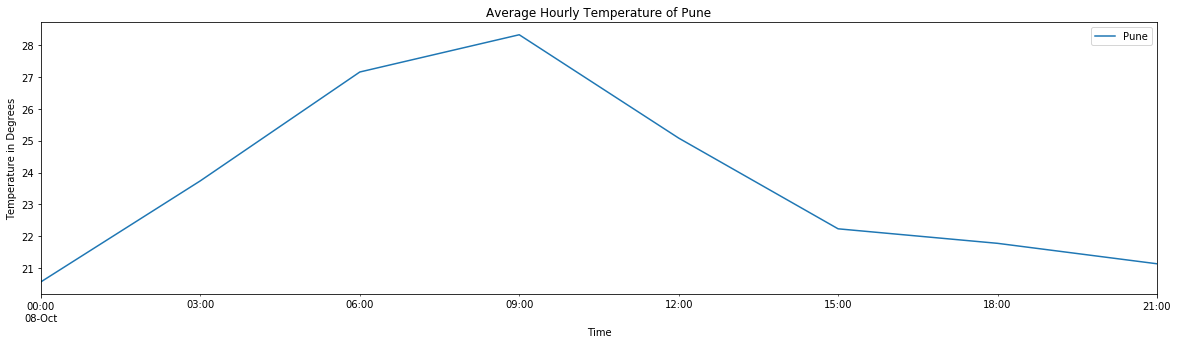

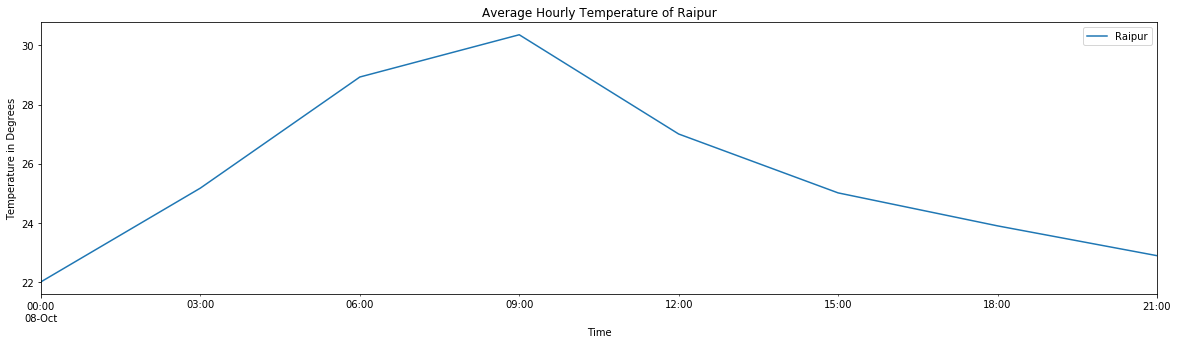

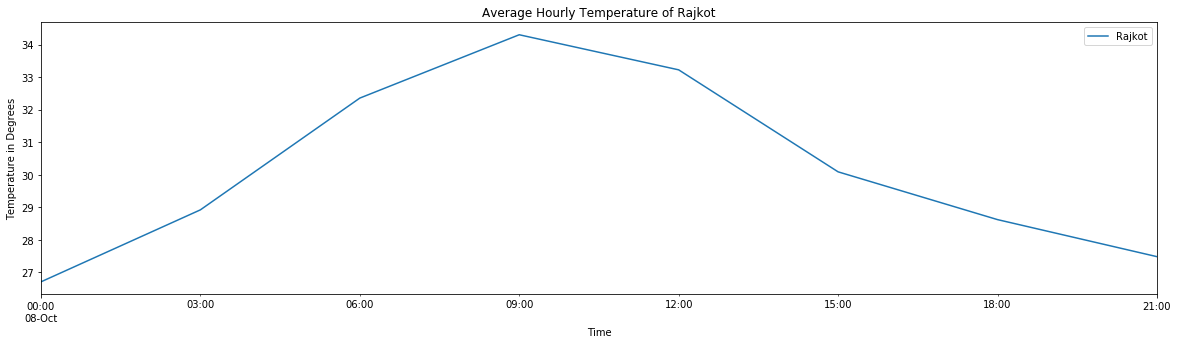

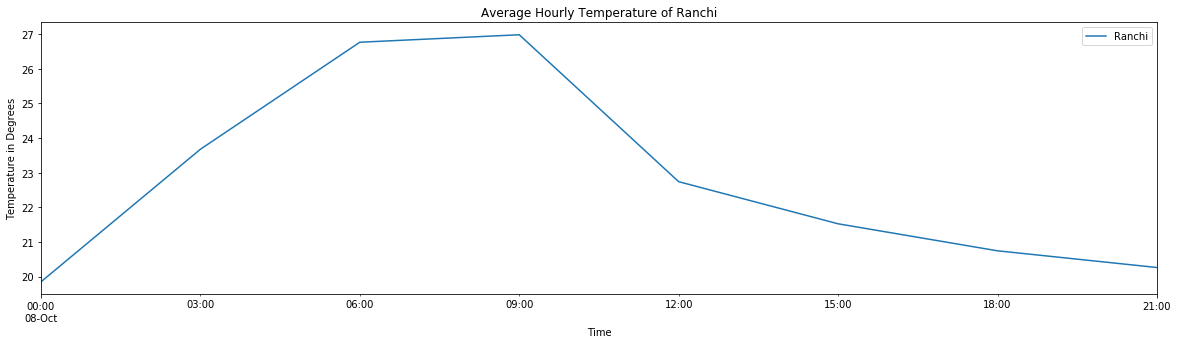

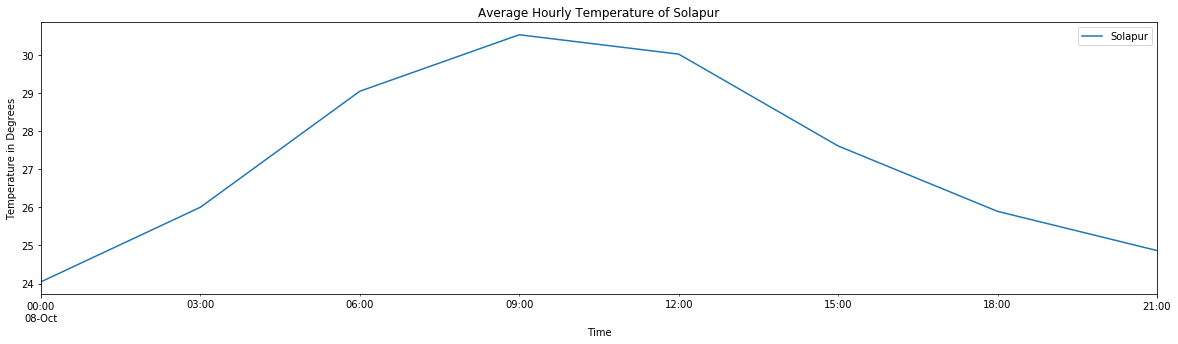

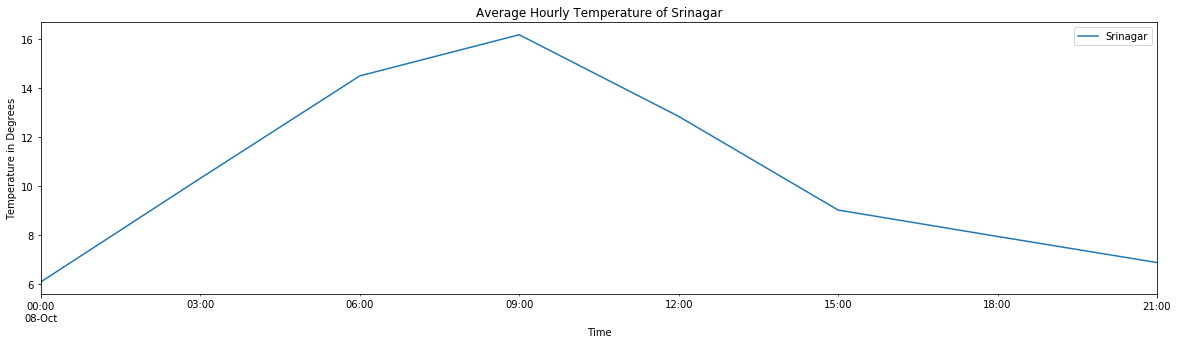

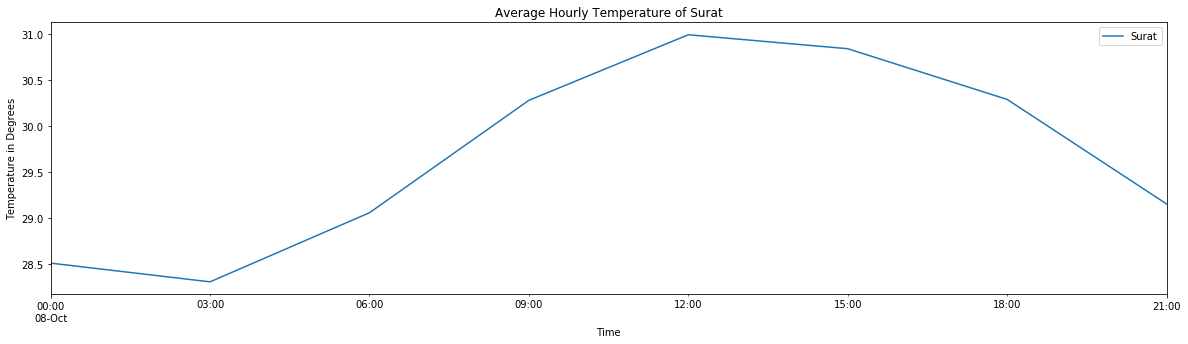

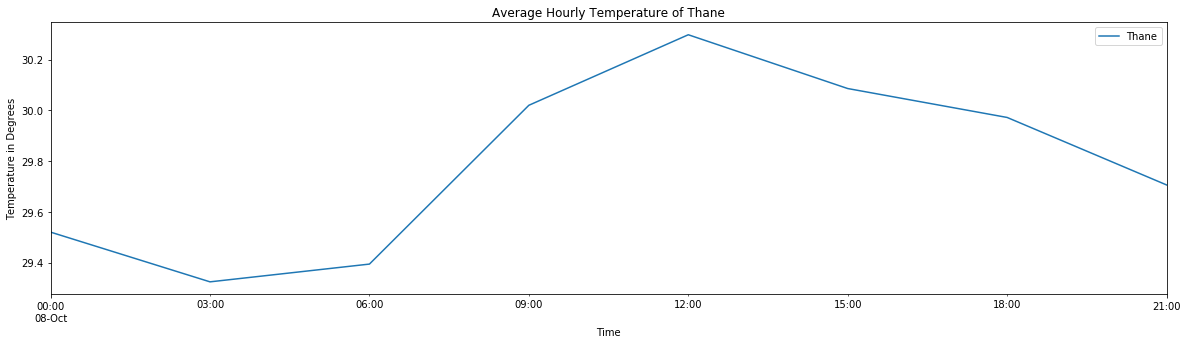

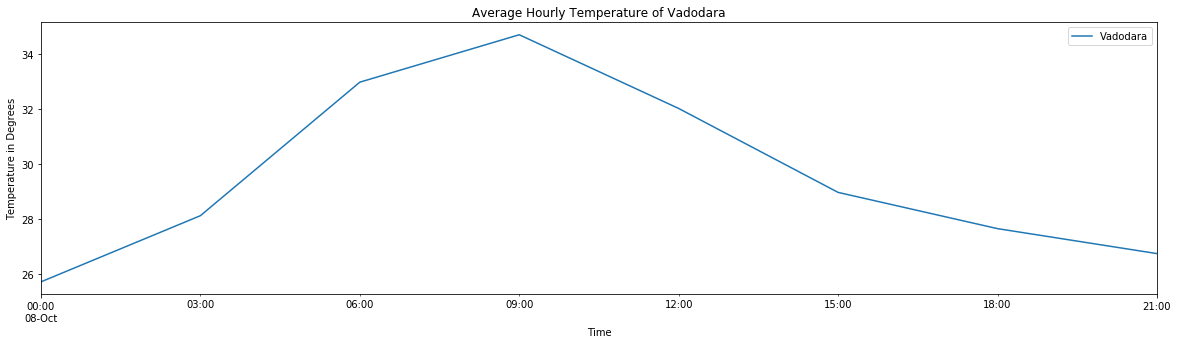

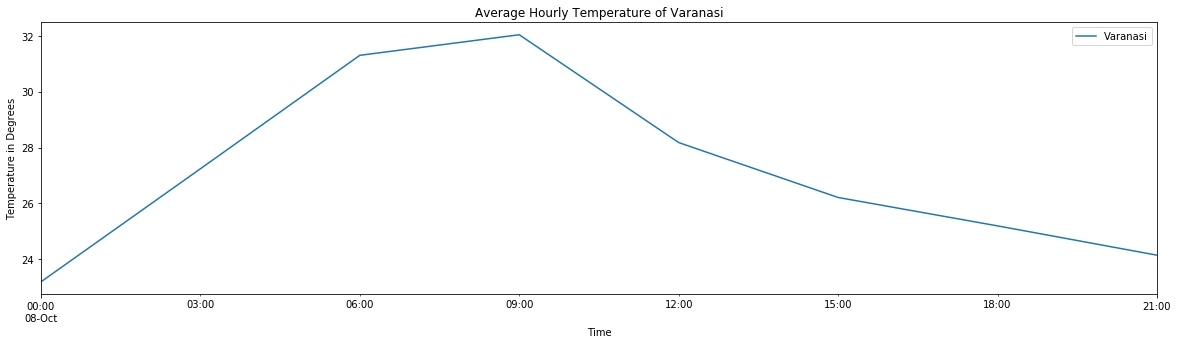

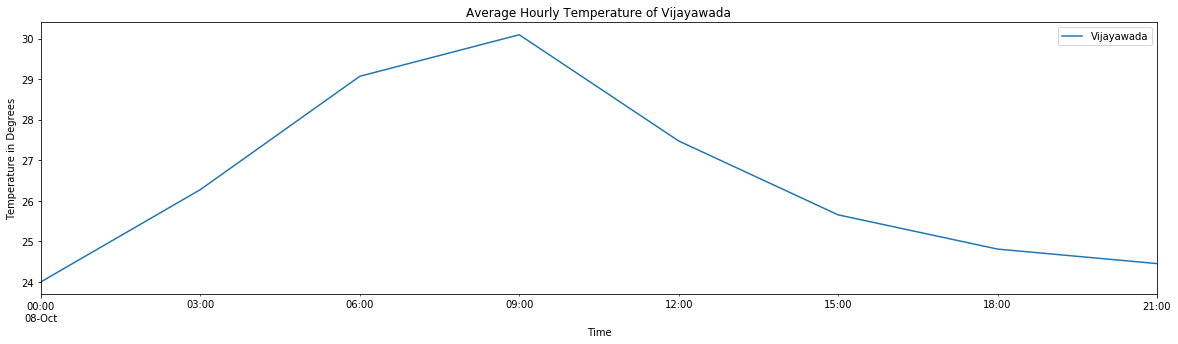

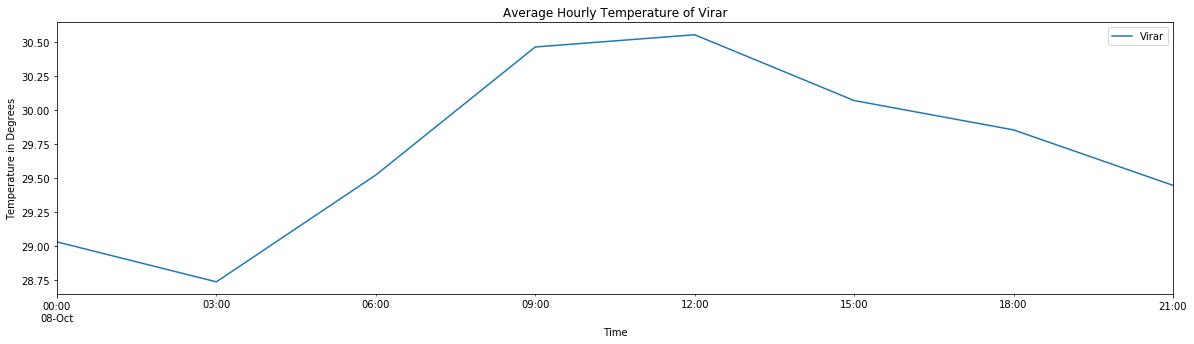

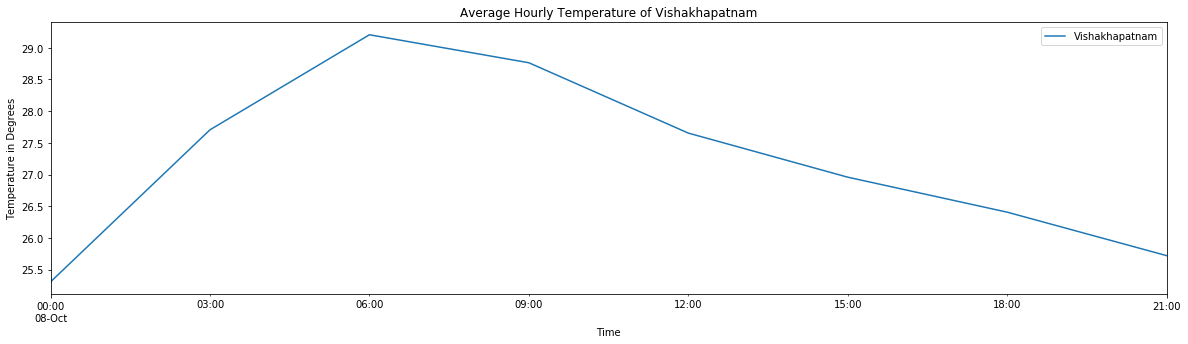

In [426]:
city_list = list(city_temp.City.unique())
for city in city_list:
    df_city = city_temp.query('City == "{0}"'.format(city))
    
    df_city.plot(x="time", y='temp_avg', figsize=(20,5), title = "Average Hourly Temperature of {0}".format(city))
    plt.xlabel('Time')
    plt.ylabel('Temperature in Degrees')
    plt.legend(['{0}'.format(city)])

**Observations :**

- 'Indore' shows unusual pattern of fall in temperature during morning hours. It is due to the fact that it is not an indian city. But, it is city in US with the same name.

## Exploratory Data Analysis

### Univariate Analysis

In [442]:
merged_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,2000.0,26.515255,4.606058,4.9700,23.95000,26.75000,29.5500,36.0800
temp_min,2000.0,26.479315,4.592621,4.9700,23.94000,26.73000,29.5275,36.0800
temp_max,2000.0,26.543245,4.603752,4.9700,23.96000,26.82000,29.5500,36.0800
pressure,2000.0,1009.814615,2.331103,1004.5800,1008.34750,1009.58000,1010.7800,1022.9300
sea_level,2000.0,1009.814615,2.331103,1004.5800,1008.34750,1009.58000,1010.7800,1022.9300
grnd_level,2000.0,976.320010,39.995679,752.3500,962.95250,984.61000,1002.7250,1012.3000
humidity,2000.0,62.142000,20.121562,16.0000,48.00000,64.00000,78.0000,97.0000
wind_speed,2000.0,2.131005,1.121401,0.0900,1.29000,1.97500,2.7400,7.0500
wind_deg,2000.0,159.364462,107.182699,0.2840,68.86775,133.35950,252.9435,359.6860
Latitude,2000.0,22.852724,5.729592,9.9261,19.01850,22.80490,26.4609,38.3529


### Multivariate Analysis

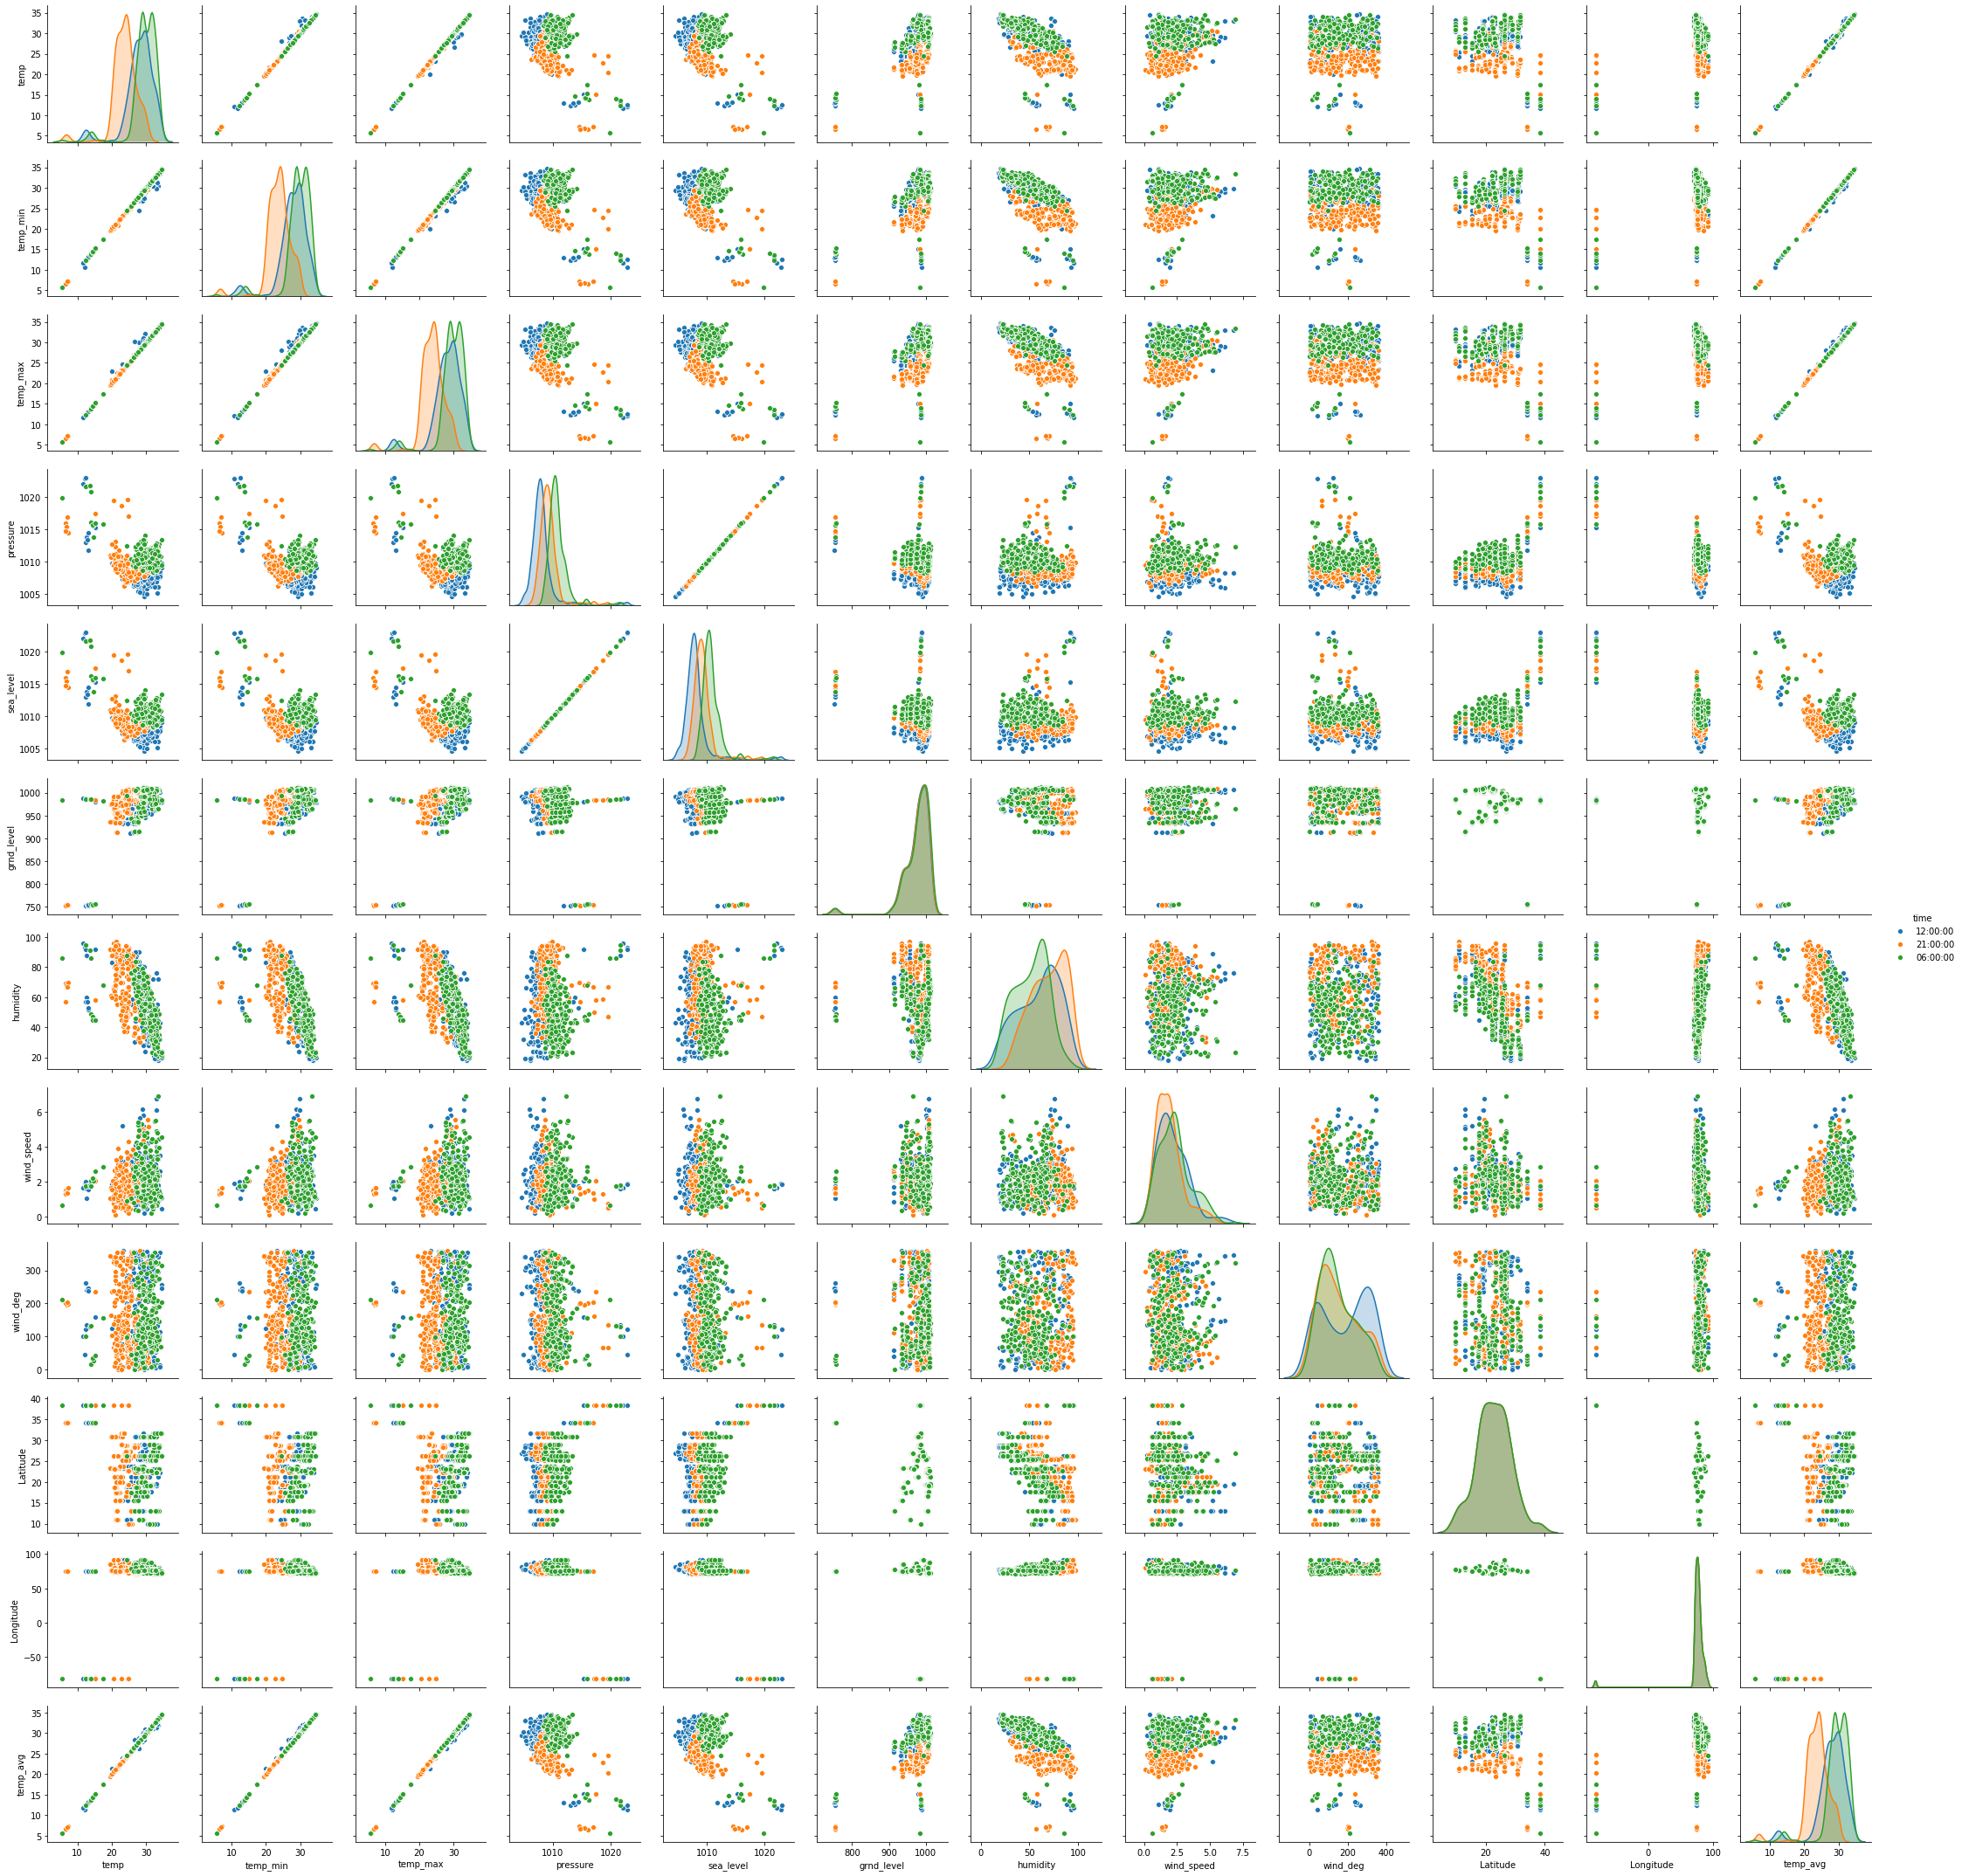

In [453]:
# Observing Data for early morning(6 AM), afternoon(12 Noon) and night time(9 PM)
mor_af_ni_data = merged_dataset.query('time in ["06:00:00","12:00:00","21:00:00"]')
sns.pairplot(mor_af_ni_data, diag_kind='kde', hue = 'time' )

**Observations :**

- As the sea-level increases, pressure increases and vice versa.
- The data-points for each variable are skewed.
- Clusters in pressure, sea-level, ground level, humidity and wind(speed+degree) are evident for each time period.
    - Pressure and Sea levelare observably lowest in afternoon and highest in early morning.
    - Similarly, Temperature variation in evident during each time block.

### Correlation Plot

In [458]:
merged_dataset.main.unique()

array(['Clear', 'Rain', 'Clouds'], dtype=object)

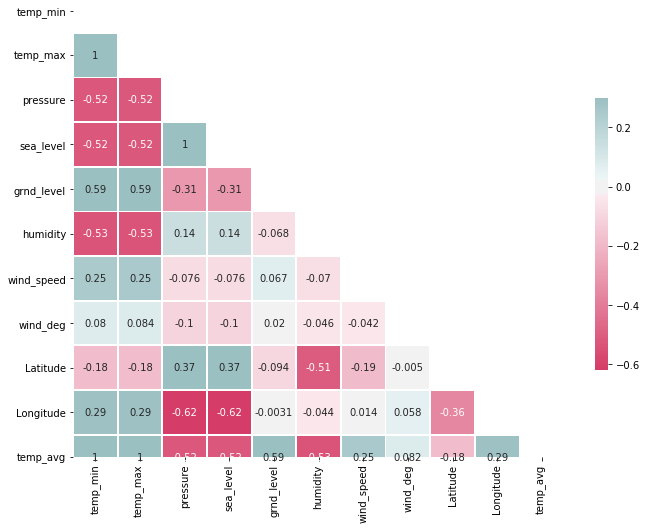

In [457]:
corr = merged_dataset[['temp_min', 'temp_max', 'pressure', 'sea_level', 'grnd_level',\
                      'humidity', 'wind_speed', 'wind_deg','Latitude', 'Longitude','temp_avg']].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(1,200, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5}, annot  = True)

**Observations:**
- Pressure is perfectly correlated with sea-level.
- Humidity, Ground level and Pressure show strong correlation with average temperature.
- Humidity is also negatively correlated with latitude i.e., with increase in latitide humidity decreases.
- Pressure/Sea-Level are negatively correlated with Longitude.

### Average Temperature Plots

In [481]:
def plot(col, category):
    """Plot of avg temp with a numeric column and hue set as a categorical column"""
    df = merged_dataset[['temp_avg', str(col), str(category)]]
    sns.pairplot(df, hue=str(category))

### avg_temp VS humidity

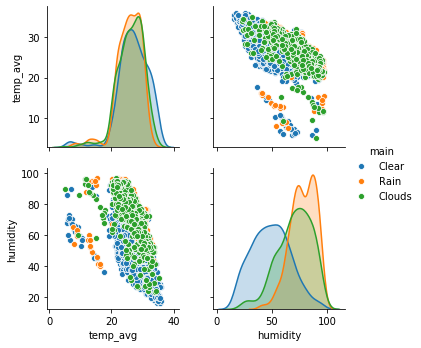

In [483]:
plot(col='humidity', category='main')

**Observation:**
- In cloudy and rainy weather, humidity is high.
- Temperature distribution remains inaffected by Sky conditions.

### avg_temp VS Pressure

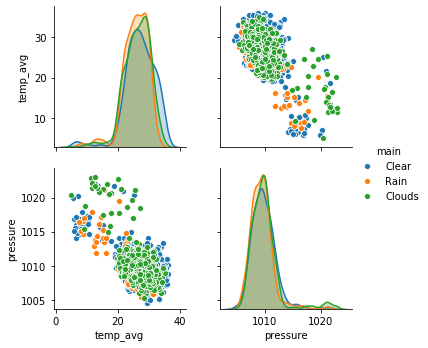

In [484]:
plot(col='pressure',category='main')

**Observations:**
- Pressure does not seem to have any effect on Sky conditions.

### avg_temp VS Wind Speed

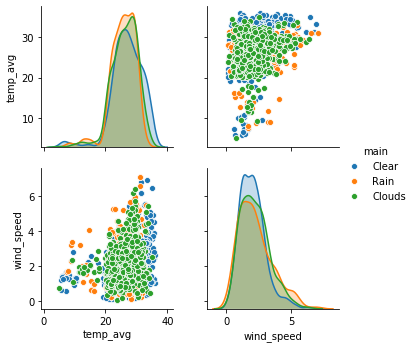

In [486]:
plot(col='wind_speed', category='main')

### avg_temp VS Wind Degree

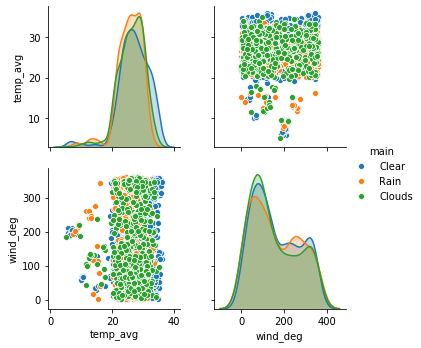

In [488]:
plot(col='wind_deg', category='main')

**Observations:**
- Wind Speed and Wind Degree remain unaffected by sky conditions.

## Statistical Analysis

- Objective: **Find the impact of various factors and their contribution on lowering average Temperature**
- Approach : **Build a Linear Regression Model to analyze the coefficients of various factors**
- Assumptions:
    - Dropping highly correlated columns.
    - Avg Temp = (min temp + max temp)/2

### Data pre-Processing

In [514]:
X = merged_dataset[['pressure', 'sea_level', 'grnd_level', 'humidity', 'wind_speed', 'wind_deg', 'main',\
                   'Latitude', 'Longitude','time']]

Y = merged_dataset.temp_min

In [515]:
## Dummification

X_dummy = pd.get_dummies(data=X, drop_first=True)

In [516]:
## Standardization

X_standard = X_dummy.apply(zscore)

### Linear Regression

In [517]:
## Linear Regression

model = sm.OLS(Y, X_standard).fit_regularized(L1_wt=1)  ### Applying LASSO Regularization for countering MultiCollinearity.

In [518]:
results = pd.DataFrame(model.params, columns=['Coefficient'])
results.sort_values(by='Coefficient')

,Coefficient
humidity,-2.746874
Latitude,-1.332385
pressure,-0.230821
wind_deg,-0.002075
sea_level,0.000000
time_21:00:00,0.162644
wind_speed,0.229753
time_18:00:00,0.322055
main_Clouds,0.411862
time_15:00:00,0.503690


**Observations:**
- **Humidity, Latitude and Pressure have negative coefficient**: So with increase of these factors Avg Temp decreases.
- **Ground Level, and time of the day have positive coefficient**: So with increase of these factors, Avg Temp increases.